In [1]:
import pandas as pd
import sys
sys.path.append("..")
from src.Utils import get_ents_spans

data = pd.read_parquet("../data/dataset/shs100k2/data.parquet").reset_index()


# Overview

In [2]:
data_spans = pd.DataFrame(pd.json_normalize(data.IOB.apply(get_ents_spans)))
data["WoA"] = data_spans.WoA
data.WoA = data.WoA.apply(lambda x: x if x == x else [])
data["Artist"] = data_spans.Artist
data.Artist = data.Artist.apply(lambda x: x if x == x else [])

data["WoA_count"] = data.WoA.apply(len)
data["Artist_count"] = data.Artist.apply(len)
data["WoA_missing"] = data.WoA_count == 0
data["Artist_missing"] = data.Artist_count == 0
data["WoA_first"] = data.WoA.apply(lambda x: x[0] if len(x) > 0 else None)
data["Artist_first"] = data.Artist.apply(lambda x: x[0] if len(x) > 0 else None)
data["WoA_len"] = data.WoA_first.apply(lambda x: x[1] + 1 - x[0] if isinstance(x, tuple) else None)
data["Artist_len"] = data.Artist_first.apply(lambda x: x[1] + 1 - x[0] if isinstance(x, tuple) else None)
data["WoA_start"] = data.WoA_first.apply(lambda x: x[0] if x else None)
data["Artist_start"] = data.Artist_first.apply(lambda x: x[0] if x else None)


# Annotated Dataset

In [3]:
data_annot = data.loc[~data.IOB_annotated.isna()]
data_annot.loc[:,
    ["split", "set_id", "yt_id", "WoA_count", "Artist_count", 
     "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
     "WoA_start", "Artist_start"]
    ].groupby("split").agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "median", "max"], "Artist_count": ["min", "median", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["min", "median", "max"], "Artist_len": ["min", "median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


set_id yt_id WoA_count            Artist_count            WoA_missing  \
      nunique count       min median max          min median max         sum   
split                                                                          
TEST       93   101         0    1.0   3            0    1.0   4           7   
TRAIN     101   106         0    1.0   2            0    1.0   3           4   
VAL        98   100         0    1.0   3            0    1.0   4           6   

      Artist_missing WoA_len              Artist_len             WoA_start  \
                 sum     min median   max        min median  max    median   
split                                                                        
TEST              28     1.0    3.0  12.0        1.0    2.0  6.0       2.0   
TRAIN             31     1.0    3.5  10.0        1.0    2.0  9.0       3.0   
VAL               21     1.0    3.0  12.0        1.0    2.0  6.0       3.0   

      Artist_start  
            median  
split               
TEST           0.0  
TRAIN          0.0  
VAL            0.0

In [24]:
data_annot.agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "median", "max"], "Artist_count": ["min", "median", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["min", "median", "max"], "Artist_len": ["min", "median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


,set_id,yt_id,WoA_count,Artist_count,WoA_missing,Artist_missing,WoA_len,Artist_len,WoA_start,Artist_start
nunique,292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,NaN,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,NaN,NaN
median,NaN,NaN,1.0,1.0,NaN,NaN,3.0,2.0,3.0,0.0
max,NaN,NaN,3.0,4.0,NaN,NaN,12.0,9.0,NaN,NaN
sum,NaN,NaN,NaN,NaN,17.0,80.0,NaN,NaN,NaN,NaN


In [6]:
data_annot.WoA_count.sum() + data_annot.Artist_count.sum()


606

/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/tor

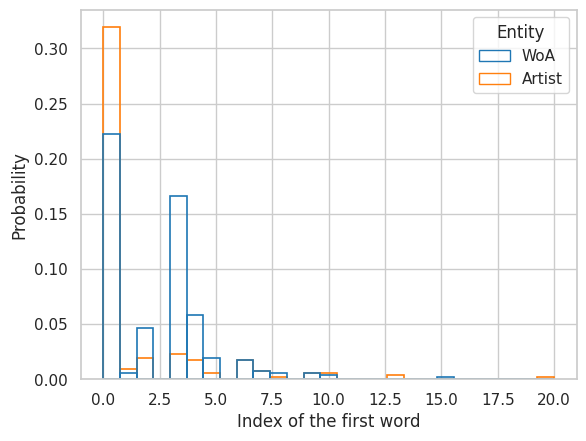

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("notebook")  # Increases font sizes for presentations
sns.histplot(
    pd.melt(
        data_annot[["yt_id", "WoA_start", "Artist_start"]].rename(
            columns={"WoA_start": "WoA", "Artist_start": "Artist"}),
        var_name="Entity", id_vars="yt_id", value_vars=["WoA", "Artist"]),
    hue="Entity",
    x="value", fill=False, stat="probability"
)


plt.xlabel("Index of the first word")
plt.savefig("../figures/kde_startindex.pdf")
plt.show()


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


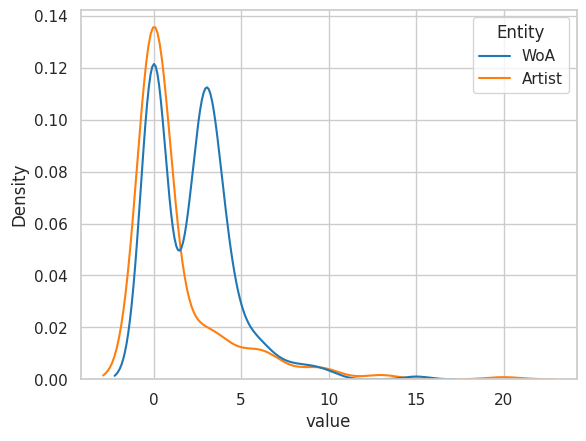

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("notebook")  # Increases font sizes for presentations
sns.kdeplot(
    pd.melt(
        data_annot[["yt_id", "WoA_start", "Artist_start"]].rename(
            columns={"WoA_start": "WoA", "Artist_start": "Artist"}),
        var_name="Entity", id_vars="yt_id", value_vars=["WoA", "Artist"]),
    hue="Entity",
    x="value"
)
plt.savefig("../figures/kde_startindex.pdf")
plt.show()


# Music Utterance Collection

In [49]:
data_utts = data[data.IOB_annotated.isna()]

data_utts.WoA_count.sum() + data_utts.Artist_count.sum()


165567

In [12]:
data_utts.title.apply(lambda x: x[0]).nunique() + data_utts.performer.apply(lambda x: x[0] if len(x) > 0 else 0).nunique()


38287

In [31]:
data["WoA_utterance"] = data.apply(
    lambda x: [' '.join(x.TEXT[span[0]:span[1]+1]) for span in x.WoA], axis=1)
data["Artist_utterance"] = data.apply(
    lambda x: [' '.join(x.TEXT[span[0]:span[1]+1]) for span in x.Artist], axis=1)



In [44]:
data[["set_id", "title", "WoA_utterance"]]

,set_id,title,WoA_utterance
0,21,[Yesterday],[yesterday]
1,21,[Yesterday],[yesterday]
2,21,[Yesterday],[yesterday]
3,21,[Yesterday],[yesterday]
4,21,[Yesterday],[yesterday]
...,...,...,...
78160,5980,"[Give Me Love (Give Me Peace on Earth), Give M...",[give me love ( give me peace on earth]
78161,5982,[I Ain't Living Long Like This],[aint living long like this]
78162,5982,[Ain't Living Long Like This],[aint living long like this]
78163,5982,[I Ain't Living Long Like This],[aint living long like this]


In [47]:
data[["set_id", "title", "WoA_utterance"]].explode("title").explode("WoA_utterance").groupby(
    ["set_id", "title"]
).agg(list)



WoA_utterance
set_id title                                                                                      
0       Summertime                                                         [nightmare, summertime]
       A Change Is Gonna Come                                 [a change is gonna come, summertime]
       Nightmare                                                           [nightmare, summertime]
       Porgy and Bess Medley                                                 [porgy & bess medley]
       Sometimes I Feel Like a Motherless Child  [summertime, summertime, sometimes i feel like...
...                                                                                            ...
9992   Vous permettez, Madame?                                             [vous permettez madame]
       Vous permettez, Monsieur                                          [vous permettez monsieur]
9993   53rd & 3rd                                                         [53rd & 3rd, 53rd & 3rd]
9994   Sytten ti                                                                       [sytten ti]
9998   I Don't Care                                                     [i dont care, i dont care]

[18953 rows x 1 columns]

In [ ]:
data[["set_id", "ver_id", "yt_id", "title", "WoA_utterance"]]


# Full Dataset

In [8]:
data[["set_id", "yt_id", "WoA_count", "Artist_count", 
                   "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
                   "WoA_start", "Artist_start"]].agg(
    {
        "set_id": pd.Series.nunique, 
        "yt_id": "count", 
        "WoA_count": ["min", "max"], 
        "Artist_count": ["min", "max"],
        "WoA_missing": "sum", 
        "Artist_missing": "sum",
        "WoA_len": ["median", "max"], 
        "Artist_len": ["median", "max"],
        "WoA_start": "median", 
        "Artist_start": "median"
    }
).max()


set_id             8768.0
yt_id             78165.0
WoA_count             4.0
Artist_count          6.0
WoA_missing          17.0
Artist_missing       80.0
WoA_len              19.0
Artist_len           10.0
WoA_start             3.0
Artist_start          0.0
dtype: float64

In [20]:
data[
    ["split", "set_id", "yt_id", "WoA_count", "Artist_count", 
     "WoA_len", "Artist_len", "WoA_missing", "Artist_missing",
     "WoA_start", "Artist_start"]
    ].groupby("split").agg(
        {"set_id": pd.Series.nunique, "yt_id": "count", 
         "WoA_count": ["min", "max"], "Artist_count": ["min", "max"],
         "WoA_missing": "sum", "Artist_missing": "sum",
         "WoA_len": ["median", "max"], "Artist_len": ["median", "max"],
         "WoA_start": "median", "Artist_start": "median"
         }
    )


set_id  yt_id WoA_count     Artist_count     WoA_missing  \
      nunique  count       min max          min max         sum   
split                                                             
TEST     1655   7755         0   3            0   6           7   
TRAIN    5304  62486         0   4            0   5           4   
VAL      1811   7924         0   3            0   4           6   

      Artist_missing WoA_len       Artist_len       WoA_start Artist_start  
                 sum  median   max     median   max    median       median  
split                                                                       
TEST              28     3.0  15.0        2.0  10.0       3.0          0.0  
TRAIN             31     3.0  19.0        2.0   9.0       3.0          0.0  
VAL               21     3.0  16.0        2.0   8.0       3.0          0.0

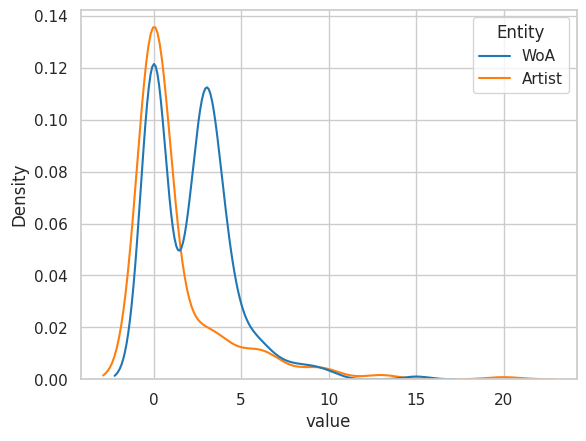

# Automatic vs. Human Annotations

In [41]:
data = data.dropna(subset="IOB_annotated")


In [46]:
from src.Eval import compute_results


compute_results(data.IOB_annotated, data.IOB_auto)


2024-08-09 08:53:41 root INFO: Imported 307 predictions for 307 true examples



 Overall
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.944954  0.49361   0.648478        309           11          0       306           7         626       327
ent_type     0.978593  0.511182  0.671563        320            0          0       306           7         626       327
exact        0.944954  0.49361   0.648478        309           11          0       306           7         626       327

 Artist
schema      precision    recall        f1    correct    incorrect    partial    missed    spurious    possible    actual
--------  -----------  --------  --------  ---------  -----------  ---------  --------  ----------  ----------  --------
strict       0.935294  0.52649   0.673729        159            6          0       137           5         302       170
ent_type     

{'overall_strict_precision_micro': 0.944954128440367,
 'overall_strict_recall_micro': 0.4936102236421725,
 'overall_strict_f1_micro': 0.6484784889821615,
 'overall_strict_correct_micro': 309,
 'overall_strict_incorrect_micro': 11,
 'overall_strict_partial_micro': 0,
 'overall_strict_missed_micro': 306,
 'overall_strict_spurious_micro': 7,
 'overall_strict_possible_micro': 626,
 'overall_strict_actual_micro': 327,
 'overall_ent_type_precision_micro': 0.9785932721712538,
 'overall_ent_type_recall_micro': 0.5111821086261981,
 'overall_ent_type_f1_micro': 0.6715634837355718,
 'overall_ent_type_correct_micro': 320,
 'overall_ent_type_incorrect_micro': 0,
 'overall_ent_type_partial_micro': 0,
 'overall_ent_type_missed_micro': 306,
 'overall_ent_type_spurious_micro': 7,
 'overall_ent_type_possible_micro': 626,
 'overall_ent_type_actual_micro': 327,
 'overall_exact_precision_micro': 0.944954128440367,
 'overall_exact_recall_micro': 0.4936102236421725,
 'overall_exact_f1_micro': 0.6484784889821